# L6

Na tych ćwiczeniach omówimy:
* model evaluation,
* model selection,
* data augmentation.


## Cross validation - przypomnienie

Najprostszym sposobem na ocenę skuteczności modelu jest podzielenie danych w losowy sposób na zbiory trenujący i testowy, wytrenowanie modelu na zbiorze trenującym i przetestowanie na zbiorze testowym. Cross validation stosujemy w celu zmniejszenia wariancji estymatora losowego podziału.

### Zasada działania

Robimy jeden duży podział - dzielimy cały zbiór na $k$ rozłącznych podzbiorów i potem $k$ razy zbiór trenujący składamy z $k-1$ kawałków, a ostatniego używamy jako zbiór testowy. Dzięki temu każdy element $D$ będzie dokładnie raz w zbiorze testowym.

<img src="figures/L3/K-fold_cross_validation_EN.jpg">

### Leave one out

Szczególnym przypadkiem jest podejście leave one out, gdzie zbiór testowy jest zawsze jednoelementowy ($k$ jest równe liczbie przykładów).

## Model evaluation

Model evaluation to cała rodzina algorytmów estymowania skuteczności nauczonego modelu. Oczywiście interesuje nas to, jak model poradzi sobie na danych, które będą pojawiały się "w prawdziwym świecie", a więc na danych pochodzących z tego samego źródła, co zbiór treningowy, lecz niekoniecznie identycznych (dane takie same, a nie te same).

### Dane i.i.d.

W najprostszym przypadku zakładamy, że dane pochodzą z tego samego rozkładu, więc możemy np.:
* podzielić dane losowo na zbiór trenujący i testowy,
* wykonać powyższe wielokrotnie i uśrednić wynik,
* użyć cross validation,
* użyć leave one out.

Za każdym razem model jest uczony od nowa na zbiorze treningowym, a testowany tylko na danych ze zbioru testowego.

W wypadku problemów klasyfikacji podział train/test możemy wykonać w sposób "stratified" - jeśli np. zbiór testowy stanowi 30% wszystkich danych, to dodatkowo wymuszamy, aby 30% danych z **każdej klasy** znalazło się w zbiorze testowym. Jest to szczególnie ważne w wypadku, gdy niektóre klasy są mało liczebne w naszych danych - w ten sposób zapobiegamy sytuacji, w której cała klasa zostanie pominięta w zbiorze treningowym lub testowym.

### Dane nie i.i.d.

Oczywiście w praktyce nie zawsze można sensownie uargumentować i.i.d. Przykładem niech będzie zbiór MNIST - każdy człowiek ma nieco inny charakter pisma, a zadanie polega na nauczeniu modelu, który dobrze radzi sobie na danych pochodzących od nowych ludzi. Dlatego też twórca MNISTa dostarcza podział train/test, który wykonany jest względem ludzi (w zbiorze treningowym znajdują się cyfry napisane przez ok. 250 osób, łącznie 60 tys. przykładów, w zbiorze testowym znajduje się 10 tys. przykładów pochodzących od innych osób). Dzięki temu sprawdzamy, czy model faktycznie generalizuje na nowy charakter pisma, a nie tylko zapamiętuje poszczególne osoby i ich styl.

W tym notebooku będziemy dla prostoty używali wszystkich danych łącznie, ale należy pamiętać, co w ten sposób tak naprawdę sprawdzamy.

### Szeregi czasowe

Bardzo często dane pochodzą z szeregu czasowego, tzn. wiersze są postaci ($\mathbf{x}$, $y$, timestamp). Jeśli zadanie polega na generalizacji w czasie - czyli oczekujemy, że nasz model będzie działał dobrze w przyszłości - to przy ewaluacji musimy wykonać podział train/test ze względu na czas (train to wszystkie dane przed pewną ustaloną datą, test to dane późniejsze). Temat szeregów czasowych wykracza poza ramy tego notebooka. 

## Model selection

Modele opisane są dwoma zestawami liczb: parametrami i hiperparametrami.

### Parametry

Parametry to zmienne, które wyznaczane są algorytmicznie podczas uczenia modelu (jawnym wzorem, metodami iteracyjnymi itp.). Przykładem są wagi w regresji liniowej, wagi w sieciach neuronowych, support vectors w SVMach, progi w drzewach decyzyjnych.

### Hiperparametry

W odróżnieniu od parametrów, hiperparametry muszą być dobrane ręcznie przed rozpoczęciem uczenia. Hiperparametry kontrolują działanie modelu, pozwalają manipulować overfittingiem itp. Przykłady: stała C w regresji liniowej, architektura sieci neuronowej (liczba i rozmiar warstw, funkcje aktywacji), wymiar podprzestrzeni w PCA, liczba drzew w Random Forest.

### Motywacja

W założeniu hiperparametry pozwalają włączyć człowieka w proces uczenia modelu - człowiek potrafi dobrać hiperparametry, ponieważ posiada intuicję dotyczącą prawdziwego świata i, w przeciwieństwie do maszyny, rozumie dany task znacznie głębiej oraz potrafi poprawnie zinterpretować działanie hiperparametrów. Natomiast znalezieniem parametrów, co jest zadaniem żmudnym, ale dobrze zdefiniowanym, może zająć się komputer.

Oczywiście to wszystko nieprawda - człowiek wcale nie ma lepszej intuicji, a zezwolenie na ręczny dobór hiperparametrów prowadzi do różnych patologii (np. testujemy dziesiątki tysięcy zestawów hiperparametów i publikujemy najlepszy wynik - zamiast dostać lepszy model zoverfitowaliśmy się do danych).

Dlatego przyjmijmy na tę chwilę inną definicję - hiperparametry (tym razem z definicji!) różnią się od parametrów tym, że nie da się ich zoptymalizować gradientowo lub jawnym wzorem. Model selection to po prostu algorytm doboru hiperparametrów.

### Przykład

Załóżmy, że mamy zbiór (X_train, y_train) oraz klasę Model, która przyjmuje w konstruktorze zestaw hiperparametrów. Możemy zrobić następująco:
* stworzyć listę zestawów hiperparametrów i dla każdego stworzyć obiekt model = Model(zestaw_hiperparametrów),
* ocenić wszystkie modele na danych (X_train, y_train),
* wybrać ten zestaw hiperparametrów, dla którego model uzyskał najlepszy wynik.

### Jak stworzyć listę zestawów hiperparametrów

Zamieniliśmy problem ręcznego doboru hiperparametrów na ręczne tworzenie listy zestawów hiperparametrów - czy w takim razie wciąż nie oszukujemy? Trochę tak, ale na szczęście trochę mniej.

Jak w praktyce tworzy się listę zestawów hiperparametrów:
1. Grid search - dla każdego hiperparametru arbitralnie tworzymy listę jego możliwych wartości, a następnie sprawdzamy wszystkie możliwe zestawy (problem: dla 10 hiperparametrów i 10 możliwości każdego z nich musimy wytrenować $10^{10}$ modelów).
2. Random grid search - robimy jak powyżej, ale losujemy $n$ zestawów ($n$ dobieramy ręcznie, np. 43) zamiast sprawdzać wszystkie.
3. Random search - dla danego hiperparametru nie definiujemy listy jego możliwych wartości, ale rozkład, z którego będziemy go losowali (np. losujemy $\alpha$ z rozkładu jednostajnego na odcinku $[-5,5]$, a potem definiujemy hiperparametr regresji liniowej $C=10^{\alpha}$); następnie zestaw hiperparametrów tworzymy losując każdy niezależnie z podanego rozkładu.

Podejście trzecie jest zdecydowanie najlepsze, co obrazuje poniższa ilustracja [proszę spróbować wytłumaczyć].

<img width=600 src="figures/L6/scikitlearn8.jpeg">

### * Optymalizacja bayesowska

Można robić jeszcze lepiej, niż random search. Rozkłady podane w random search traktujemy jako naszą wiedzę a priori o położeniu najlepszego zestawu hiperparametrów, a następnie po każdym losowaniu ewaluujemy model i uzyskany wynik włączamy do naszej wiedzy. Szczegóły są nieco skomplikowane (musimy założyć trochę dodatkowych własności o tym, jak wynik modelu zależy od położenia w przestrzeni hiperparametrów), natomiast zainteresowane osoby mogą spróbować zapoznać się np. z następującymi implementacjami:
* http://hyperopt.github.io/hyperopt/
* https://github.com/msmbuilder/osprey

## Podsumowanie

Zakładamy, że Model to klasa, a model to instancja. Model przyjmuje w konstruktorze wszystkie hiperparametry. Dane to (X,y). Model selection i model evaluation wykonujemy przy pomocy 3-fold cross validation. Ustalamy też listę zestawów hiperparametrów.

### Ważna i subtelna uwaga

Techniki model evaluation możemy stosować tylko do konkretnych algorytmów. Dlatego nie możemy zewaluować regresji liniowiej, tylko np. regresję liniową ze stałą C=3. Nie możemy ewaluować klasy Model, tylko obiekt model.

Ale gdy zdecydujemy się na pewien algorytm doboru hiperparametrów, to możemy zapisać:

(Model + model_selection) = metamodel

gdzie metamodel da się fitować (parametry **oraz hiperparametry** zostaną dobrane automatycznie tylko na podstawie danych). W tym sensie możemy ewaluować klasę Model.

Warto też zwrócić uwagę, że dla różnych model_selection dostaniemy różne metamodele. Np. jeśli raz za model_selection użyjemy strategii cross validation z 3 foldami, a za drugim razem np. leave one out, to te dwa metamodele będą miały różną zasadę działania i przez to inny score (nawet jeśli w obu przypadkach Model to np. regresja liniowa).

### Algorytmy

Aby zewaluować Model (metamodel):
1. Dzielimy trzy razy (X,y) na (X_train,y_train), (X_test,y_test).
2. Dla każdego takiego podziału:
    1. Dzielimy trzy razy (X_train,y_train) na (X_train2,y_train2), (X_valid,y_valid).
    2. Dla każdego zestawu hiperparametrów:
        1. Dla każdego podziału (X_train2,y_train2), (X_valid,y_valid):
            1. Tworzymy model = Model(zestaw_hiperparametrów).
            2. Uczymy model na (X_train2,y_train2), testujemy na (X_valid,y_valid) i otrzymujemy score.
            3. (zestaw_hiperparametrów, score) zapisujemy w tabelce.
    3. Dla każdego zestawu hiperparametrów mamy trzy różne score z trzech podziałów - uśredniamy je.
    4. Wybieramy średnio najlepszy zestaw hiperparametrów.
    5. Tworzymy model = Model(średnio_najlepszy_zestaw_hiperparametrów) i uczymy na całym (X_train,y_train).
    6. Testujemy model na (X_test,y_test) i otrzymujemy evaluation_score, zapisujemy go.
3. Uśredniamy trzy evaluation_score, zwracamy średnią jako ostateczny score Modelu.

Uwaga - dla różnych (X_train,y_train) mamy różne ostatecznie wybrane średnio_najlepszy_zestaw_hiperparametrów, tak właśnie ma być [proszę się zastanowić, dlaczego].

Aby wytrenować metamodel:
1. Dzielimy trzy razy (X,y) na (X_train,y_train), (X_valid,y_valid).
2. Dla każdego zestawu hiperparametrów:
    1. Dla każdego podziału (X_train,y_train), (X_valid,y_valid):
        1. Tworzymy model = Model(zestaw_hiperparametrów).
        2. Uczymy model na (X_train,y_train), testujemy na (X_valid,y_valid) i otrzymujemy score.
        3. (zestaw_hiperparametrów, score) zapisujemy w tabelce.
3. Dla każdego zestawu hiperparametrów mamy trzy różne score z trzech podziałów - uśredniamy je.
4. Wybieramy średnio najlepszy zestaw hiperparametrów.
5. Tworzymy model = Model(średnio_najlepszy_zestaw_hiperparametrów) i uczymy na całym (X,y).

Uwaga - teraz mamy tylko jeden średnio_najlepszy_zestaw_hiperparametrów i jeden model.

W ten sposób otrzymujemy:
1. model - ten model (wytrenowany metamodel) idzie do produkcji.
2. score - estymacja skuteczności klasy Model jest dość dobrą estymacją tego, jak model poradzi sobie w przyszłości.
3. średnio_najlepszy_zestaw_hiperparametrów - informacyjnie możemy też podać znaleziony najlepszy zestaw hiperparametrów, jednakże w tym momencie nie różni się on koncepcyjnie od wytrenowanego zestawu **parametrów**; nie możemy twierdzić, że te hiperparametry będą zawsze najlepsze, ponieważ ucząc się na innych danych możemy dostać inne wartości średnio najlepszych hiperparametrów.

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from numpy.random import RandomState
from itertools import product

# dane
from sklearn.datasets import fetch_mldata
# splity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
# modele
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
# metryki
from sklearn.metrics import accuracy_score

mnist = fetch_mldata('MNIST original')
X = mnist["data"]
y = mnist["target"]

# zawsze przed uczeniem/splitami proszę zrobić shuffle na danych!

Czego będziemy używać:
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* http://yann.lecun.com/exdb/mnist/

Uwaga - modele będą się uczyły dłużej, niż zwykle. Warto dodać w kodzie dużo printów, żeby na bieżąco wiedzieć, co się dzieje.

Na etapie pisania i testowania kodu można też zmniejszyć sobie losowo MNISTa np. do 5% przykładów, aby testy przebiegały szybciej.

## Ćwiczenie 1 [2 pkt]

Napisać trzy generatory zestawów hiperparametrów:
* generator grid search [robimy wspólnie za 0 pkt],
* generator k elementów random grid search,
* generator k elementów random search.

Hiperparametry podajemy jako słownik {nazwa_hiperparametru: lista_wartości/rozkład}.

Generator ma yieldować słowniki {nazwa_hiperparametru: wartość_hiperparametru}

Rozkłady prawdopodobieństwa możecie Państwo podawać w dowolny sposób - np. jako pythonową funkcję, jako string z nazwą (a możliwe rozkłady zakodować na sztywno w funkcji zwracającej generatory) itp. Proponuję zastosować konwencję opisaną w następnej komórce [czy ktoś z Państwa ma inny pomysł, jak podawać rozkłady?].

Losowe generatory mają przyjmować random_state i działać deterministycznie przy ustalonym random_state (należy ustawić w środku seed generatora liczb losowych na random_state).


In [2]:
# Tworzymy fabryki samplerów, każda fabryka parametryzuje pewną rodzinę rozkładów prawdopodobieństwa
# sampler pamięta jeden konkretny rozkład prawdopodobieństwa
# jedynym argumentem samplera jest obiekt numpy.random.RandomState, który oznaczamy rng
# sampler zwraca jedną wartość ze swojego rozkładu
# ponieważ rng pamięta swój stan, to możemy np. raz stworzyć go na początku i podawać w pętli

# rodzina rozkładów jednostajnych na podanych listach elementów
# sampler losuje z rozkładu jednostajnego na liście l
def uniform_from_list(l):
    def sampler(rng):
        return l[rng.randint(0,len(l))]
    return sampler

# rodzina rozkładów jednostajnych na przedziałach liczb całkowitych
# sampler losuje z rozkładu jednostajnego na podzbiorze liczb całkowitych od low (włącznie) do high (wyłącznie)
def uniform_int_on_interval(low, high):
    def sampler(rng):
        return rng.randint(low,high)
    return sampler

# rodzina rozkładów jednostajnych na przedziałach
# sampler losuje z rozkładu jednostajnego na przedziale [low, high]
def uniform_on_interval(low, high):
    def sampler(rng):
        return rng.uniform(low, high)
    return sampler

# rodzina rozkładów jednostajnych na przedziałach w wykładniku potęgi liczby 10
# sampler losuje liczbę alpha z rozkładu jednostajnego na przedziale [low, high], a następnie zwraca 10^alpha
def log_uniform_on_interval(low, high):
    def sampler(rng):
        return 10.**rng.uniform(low, high)
    return sampler

# rodzina rozkładów gaussa
# sampler losuje liczbę z rozkładu N(mean, std^2)
def normal(mean, std):
    def sampler(rng):
        return rng.normal(loc=mean, scale=std)
    return sampler

# rodzina rozkładów gaussa w wykładniku potęgi liczby 10
# sampler losuje liczbę alpha z rozkładu N(mean, std^2), a następnie zwraca 10^alpha
def log_normal(mean, std):
    def sampler(rng):
        return 10**rng.normal(loc=mean, scale=std)
    return sampler

In [3]:
print "Tworzymy obiekt klasy RandomState"
rng = RandomState(743)
s1 = normal(0.,1.)
s2 = log_uniform_on_interval(-4.,4.)
s3 = uniform_int_on_interval(-2,5)
print "Losujemy..."
for _ in xrange(4):
    print s1(rng), s2(rng), s3(rng)

print ""
print "Resetujemy RandomState"
rng = RandomState(743)
s1 = normal(0.,1.)
s2 = log_uniform_on_interval(-4.,4.)
s3 = uniform_int_on_interval(-2,5)
print "Losujemy..."
for _ in xrange(4):
    print s1(rng), s2(rng), s3(rng)

print ""
print "Resetujemy RandomState"
rng = RandomState(743)
s1 = normal(0.,1.)
s2 = log_uniform_on_interval(-4.,4.)
s3 = uniform_int_on_interval(-2,5)
print "Losujemy w innej kolejności, wypisujemy w starej..."
for _ in xrange(4):
    _s3 = s3(rng)
    _s2 = s2(rng)
    _s1 = s1(rng)
    print _s1, _s2, _s3

print ""
print "samplery współdzielą rng, kolejność losowania ma znaczenie!"

Tworzymy obiekt klasy RandomState
Losujemy...
-0.842587612353 0.000472401243122 0
0.153322909413 543.807159801 -2
-0.341758747593 1765.13251908 3
-0.593715774857 8.32922889041 -1

Resetujemy RandomState
Losujemy...
-0.842587612353 0.000472401243122 0
0.153322909413 543.807159801 -2
-0.341758747593 1765.13251908 3
-0.593715774857 8.32922889041 -1

Resetujemy RandomState
Losujemy w innej kolejności, wypisujemy w starej...
-1.50310753692 5.57429041087 4
0.394467225601 0.000472401243122 0
0.343807964283 543.807159801 0
-0.775106170237 1765.13251908 4

samplery współdzielą rng, kolejność losowania ma znaczenie!


In [10]:
def grid_search(grid):
    (keys, values_grid) = zip(*grid.iteritems())
    for values in product(*values_grid):
        yield dict(zip(keys, values))

def random_grid_search(grid, k=20, random_state=43):
    rng = RandomState(random_state) # ustalamy jeden wspólny rng
    (keys, values_grid) = zip(*grid.iteritems())
    # wysamplować k zestawów hiperparametrów
    sampler = uniform_from_list(list(product(*values_grid)))
    for _ in range(k):
        yield dict(zip(keys, sampler(rng)))

def random_search(grid, k=20, random_state=43):
    rng = RandomState(random_state) # ustalamy jeden wspólny rng
    (keys, samplers) = zip(*sorted(grid.iteritems())) # sortujemy klucze, kolejność samplowania jest ważna!
    # wysamplować k zestawów hiperparametrów
    for _ in range(k):
        values = [sampler(rng) for sampler in samplers]
        yield dict(zip(keys, values))


In [11]:
# assert dla grid_search
for d in grid_search({'C': [0.1, 1., 10., 100.], 'gamma': [0.0001, 0.0003, 0.001]}):
    print d

{'C': 0.1, 'gamma': 0.0001}
{'C': 0.1, 'gamma': 0.0003}
{'C': 0.1, 'gamma': 0.001}
{'C': 1.0, 'gamma': 0.0001}
{'C': 1.0, 'gamma': 0.0003}
{'C': 1.0, 'gamma': 0.001}
{'C': 10.0, 'gamma': 0.0001}
{'C': 10.0, 'gamma': 0.0003}
{'C': 10.0, 'gamma': 0.001}
{'C': 100.0, 'gamma': 0.0001}
{'C': 100.0, 'gamma': 0.0003}
{'C': 100.0, 'gamma': 0.001}


{'C': 0.1, 'gamma': 0.0001}<br/>
{'C': 0.1, 'gamma': 0.0003}<br/>
{'C': 0.1, 'gamma': 0.001}<br/>
{'C': 1.0, 'gamma': 0.0001}<br/>
{'C': 1.0, 'gamma': 0.0003}<br/>
{'C': 1.0, 'gamma': 0.001}<br/>
{'C': 10.0, 'gamma': 0.0001}<br/>
{'C': 10.0, 'gamma': 0.0003}<br/>
{'C': 10.0, 'gamma': 0.001}<br/>
{'C': 100.0, 'gamma': 0.0001}<br/>
{'C': 100.0, 'gamma': 0.0003}<br/>
{'C': 100.0, 'gamma': 0.001}

In [6]:
# assert dla random_grid_search
# ma wyjść tak samo, jak random_search, tylko z podanymi samplerami uniform_from_list
# proszę sobie sprawdzić we własnym zakresie, my uwierzymy na słowo

In [12]:
for d in random_search(
        {'C': log_uniform_on_interval(-5., 5.),
         'gamma': uniform_on_interval(0.,0.1),
         'nb_sth': uniform_from_list([1,4,9,13,22])},
        k=15,
        random_state=43):
    print d

{'C': 0.00014143134252521947, 'nb_sth': 9, 'gamma': 0.06090665392794814}
{'C': 0.0025462216096392796, 'nb_sth': 13, 'gamma': 0.03271390558111398}
{'C': 5.590022241698091e-05, 'nb_sth': 1, 'gamma': 0.004505286023886656}
{'C': 1.950465371399982e-05, 'nb_sth': 13, 'gamma': 0.0733748296280283}
{'C': 0.0002976304542098269, 'nb_sth': 13, 'gamma': 0.0011286104130902254}
{'C': 3.705521747936987e-05, 'nb_sth': 22, 'gamma': 0.08666486408992002}
{'C': 31.420766577465653, 'nb_sth': 22, 'gamma': 0.05808772319264447}
{'C': 5.842880444285076e-05, 'nb_sth': 1, 'gamma': 0.08432246942297046}
{'C': 16.058920736060898, 'nb_sth': 22, 'gamma': 0.04037700398666926}
{'C': 35065.59811614318, 'nb_sth': 22, 'gamma': 0.04457583608397189}
{'C': 6.683446823678905e-05, 'nb_sth': 13, 'gamma': 0.08970985799815344}
{'C': 965.8767858660282, 'nb_sth': 1, 'gamma': 0.0332329385020804}
{'C': 0.28068153065434537, 'nb_sth': 1, 'gamma': 0.08247676837174123}
{'C': 12207.52376193616, 'nb_sth': 13, 'gamma': 0.09101530757801567}
{

{'C': 0.00014143134252521947, 'nb_sth': 9, 'gamma': 0.06090665392794814}<br/>
{'C': 0.0025462216096392796, 'nb_sth': 13, 'gamma': 0.03271390558111398}<br/>
{'C': 5.590022241698091e-05, 'nb_sth': 1, 'gamma': 0.004505286023886656}<br/>
{'C': 1.950465371399982e-05, 'nb_sth': 13, 'gamma': 0.0733748296280283}<br/>
{'C': 0.0002976304542098269, 'nb_sth': 13, 'gamma': 0.0011286104130902254}<br/>
{'C': 3.705521747936987e-05, 'nb_sth': 22, 'gamma': 0.08666486408992002}<br/>
{'C': 31.420766577465653, 'nb_sth': 22, 'gamma': 0.05808772319264447}<br/>
{'C': 5.842880444285076e-05, 'nb_sth': 1, 'gamma': 0.08432246942297046}<br/>
{'C': 16.058920736060898, 'nb_sth': 22, 'gamma': 0.04037700398666926}<br/>
{'C': 35065.59811614318, 'nb_sth': 22, 'gamma': 0.04457583608397189}<br/>
{'C': 6.683446823678905e-05, 'nb_sth': 13, 'gamma': 0.08970985799815344}<br/>
{'C': 965.8767858660282, 'nb_sth': 1, 'gamma': 0.0332329385020804}<br/>
{'C': 0.28068153065434537, 'nb_sth': 1, 'gamma': 0.08247676837174123}<br/>
{'C': 12207.52376193616, 'nb_sth': 13, 'gamma': 0.09101530757801567}<br/>
{'C': 0.00015294037493259258, 'nb_sth': 9, 'gamma': 0.09375550594407336}

## Ćwiczenie 2 [0 pkt]

Zaimplementować algorytm model selection z użyciem cross validation (StratifiedKFold w sklearn) zgodnie z opisem w sekcji "Podsumowanie".

In [13]:
def skf_model_selection(Model, hyperparams_generator, X, y, metric, n_splits, random_state):
    """
    Model - klasa modelu
    hyperparams_generator - generator hiperparametrów
    X,y - dane i etykiety
    metric - funkcja o sygnaturze metric(y_true, y_pred), która ocenia skuteczność nauczonego modelu
    n_splits - liczba splitów/foldów w cross validation
    random_state - używany wszędzie tam, gdzie trzeba
    """
    
    scores = []
    tested_hyperparams = []
    
    # Aby wytrenować metamodel:
    # 1. Dzielimy n_splits (X,y) na (X_train,y_train), (X_valid,y_valid).
        # dla przejrzystości algorytmu zapamiętujemy indeksy podziału w liście indices
        # w normalnym kodzie trzeba np. wielokrotnie stworzyć generator skf głębiej w pętli
    indices = []
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    for train_index, valid_index in skf.split(X,y):
        indices.append((train_index, valid_index))
    # 2. Dla każdego zestawu hiperparametrów:
    for hyperparams in hyperparams_generator:
        # 1. Dla każdego podziału (X_train,y_train), (X_valid,y_valid):
        scores.append([])
        print "Testujemy hiperparametry:", hyperparams
        for i, (train_index, valid_index) in enumerate(indices):
            X_train, y_train = X[train_index], y[train_index]
            X_valid, y_valid = X[valid_index], y[valid_index]
            # 1. Tworzymy model = Model(zestaw_hiperparametrów).
            model = Model(**hyperparams)
            # 2. Uczymy model na (X_train,y_train), testujemy na (X_valid,y_valid) i otrzymujemy score.
            print "Uczymy model - split " + str(i+1) + "/" + str(n_splits) + "..."
            model.fit(X_train, y_train)
            print "Liczymy score..."
            score = metric(y_valid, model.predict(X_valid)) # w zależności od metryki czasem używa się model.predict_proba, tu zakładamy, że metryka jest typu 'accuracy'
            print "Train score:", metric(y_train, model.predict(X_train))
            print "Valid score:", score
            # 3. (zestaw_hiperparametrów, score) zapisujemy w tabelce.
            scores[-1].append(score)
        tested_hyperparams.append(hyperparams)
    # 3. Dla każdego zestawu hiperparametrów mamy trzy różne score z trzech podziałów - uśredniamy je.
    avg_scores = [np.mean(scores_for_single_hyperparams) for scores_for_single_hyperparams in scores]
    # 4. Wybieramy średnio najlepszy zestaw hiperparametrów.
    best_hyperparams = tested_hyperparams[np.argmax(avg_scores)]
    print "Najlepszy zestaw hiperparametrów:", best_hyperparams
    # 5. Tworzymy model = Model(średnio_najlepszy_zestaw_hiperparametrów) i uczymy na całym (X,y).
    best_model = Model(**best_hyperparams)
    print "Uczymy najlepszy model..."
    best_model.fit(X, y)
    # Uwaga - teraz mamy tylko jeden średnio_najlepszy_zestaw_hiperparametrów i jeden model.
    return best_model, best_hyperparams


In [14]:
# przetestujmy powyższe na losowym podzbiorze MNISTa

idx = np.random.RandomState(743).permutation(len(y))
_X = X[idx[:3000]]
_y = y[idx[:3000]]

best_model, best_hyperparams = skf_model_selection(
    Model=KNeighborsClassifier,
    hyperparams_generator=grid_search({'n_neighbors': [2,5,8], 'leaf_size': [20,30,40]}),
    X=_X, y=_y,
    metric=accuracy_score,
    n_splits=2,
    random_state=43)

Testujemy hiperparametry: {'n_neighbors': 2, 'leaf_size': 20}
Uczymy model - split 1/2...
Liczymy score...
Train score: 0.954636424283
Valid score: 0.893404397069
Uczymy model - split 2/2...
Liczymy score...
Train score: 0.950699533644
Valid score: 0.886591060707
Testujemy hiperparametry: {'n_neighbors': 2, 'leaf_size': 30}
Uczymy model - split 1/2...
Liczymy score...
Train score: 0.954636424283
Valid score: 0.893404397069
Uczymy model - split 2/2...
Liczymy score...
Train score: 0.950699533644
Valid score: 0.886591060707
Testujemy hiperparametry: {'n_neighbors': 2, 'leaf_size': 40}
Uczymy model - split 1/2...
Liczymy score...
Train score: 0.954636424283
Valid score: 0.893404397069
Uczymy model - split 2/2...
Liczymy score...
Train score: 0.950699533644
Valid score: 0.886591060707
Testujemy hiperparametry: {'n_neighbors': 5, 'leaf_size': 20}
Uczymy model - split 1/2...
Liczymy score...
Train score: 0.939959973316
Valid score: 0.90872751499
Uczymy model - split 2/2...
Liczymy score...
T

## Ćwiczenie 3 [4 pkt]

Zaimplementować algorytm model selection z użyciem podwójnej cross validation (StratifiedKFold w sklearn) zgodnie z opisem w sekcji "Podsumowanie".

In [35]:
def double_skf_model_evaluation(Model, generator_function, generator_function_kwargs, X, y, metric, selection_n_splits, evaluation_n_splits, random_state):
    """
    Model - klasa modelu
    generator_function, generator_function_kwargs - chcemy zrobić coś w stylu:
        for hyperparams in generator_function(**generator_function_kwargs):
            ...
        nie podajemy wprost generatora, bo trzeba go użyć wielokrotnie, a generatorów (chyba?) nie da się kopiować
    X,y - dane i etykiety
    metric - funkcja o sygnaturze metric(y_true, y_pred), która ocenia skuteczność nauczonego modelu
    selection/evaluation_n_splits - liczba splitów/foldów w odpowiednim cross validation
    random_state - używany wszędzie tam, gdzie trzeba
    """

    scores = []
    # 1. Dzielimy evaluation_n_splits razy (X,y) na (X_train,y_train), (X_test,y_test).
    skf = StratifiedKFold(n_splits = evaluation_n_splits, random_state = random_state, shuffle = True)
    # 2. Dla każdego takiego podziału:
    for train, test in skf.split(X, y):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]

        # 1. Dzielimy selection_n_splits razy (X_train,y_train) na (X_train2,y_train2), (X_valid,y_valid).
        inner_skf = StratifiedKFold(n_splits = selection_n_splits, random_state = random_state, shuffle = True)
        inner_splits = []
        for inner_train, inner_test in inner_skf.split(X_train, y_train):
            inner_splits.append((inner_train, inner_test))
            
        hyperparams_table = []
        # 2. Dla każdego zestawu hiperparametrów:
        for hyperparams in generator_function(generator_function_kwargs):
            # 1. Dla każdego podziału (X_train2,y_train2), (X_valid,y_valid):
            for train2, valid in inner_splits:
                X_train2, y_train2 = X[train2], y[train2]
                X_valid, y_valid = X[valid], y[valid]

                # 1. Tworzymy model = Model(zestaw_hiperparametrów).
                model = Model(**hyperparams)
                # 2. Uczymy model na (X_train2,y_train2), testujemy na (X_valid,y_valid) i otrzymujemy score.
                model.fit(X_train2, y_train2)
                score = metric(y_valid, model.predict(X_valid))
                # 3. (zestaw_hiperparametrów, score) zapisujemy w tabelce.
                hyperparams_table.append((hyperparams, score))
        # 3. Dla każdego zestawu hiperparametrów mamy trzy różne score z trzech podziałów - uśredniamy je.
        hyperparams_means = []
        means = []
        for hyperparams, score in hyperparams_table:
            mean = np.mean(score)
            hyperparams_means.append((hyperparams, mean))
            means.append(mean)
        # 4. Wybieramy średnio najlepszy zestaw hiperparametrów.
        best_hyperparams = next((hyperparams for hyperparams in hyperparams_means if hyperparams[1] == max(means)), None)
        # 5. Tworzymy model = Model(średnio_najlepszy_zestaw_hiperparametrów) i uczymy na całym (X_train,y_train).
        model = Model(**best_hyperparams[0])
        model.fit(X_train, y_train)
        # 6. Testujemy model na (X_test,y_test) i otrzymujemy evaluation_score, zapisujemy go.
        evaluation_score = metric(y_test, model.predict(X_test))
        scores.append(evaluation_score)
    # 3. Uśredniamy trzy evaluation_score, zwracamy średnią jako ostateczny score Modelu.
    score = np.mean(scores)
    return score

## Ćwiczenie 4 [2 pkt]

Przy użyciu powyższych funkcji wytrenować porządnie na danych MNIST jeden (dowolnie wybrany) z poniższych modelów:
* LinearSVM,
* SVM,
* RandomForest,
* KNN.

Zwrócić model i jego estymowany score.

[Możemy wspólnie zastanowić się nad sensownym doborem gridów/rozkładów na hiperparametrach.]

In [36]:
idx = np.random.RandomState(743).permutation(len(y))
_X = X[idx[:3000]]
_y = y[idx[:3000]]

score = double_skf_model_evaluation(
    Model = KNeighborsClassifier,
    generator_function = grid_search,
    generator_function_kwargs = {'n_neighbors': [2,5,8], 'leaf_size': [20,30,40]},
    X = _X, y = _y,
    metric = accuracy_score,
    selection_n_splits = 2, evaluation_n_splits = 2,
    random_state = 43)
print score

0.906665291851


## Data augmentation

Model zawsze nauczy się lepiej na większym zbiorze danych. Przez data augmentation rozumiemy cały zbiór technik, które pozwalają "sztucznie" niskim kosztem powiększyć dataset. Oczywiście musimy znać etykiety nowowygenerowanych danych. Zazwyczaj działamy w następujący sposób: definiujemy operację, którą możemy zadziałać na pojedynczy $\mathbf{x}$ bez zmiany odpowiadającego mu $y$, a następnie generujemy z jednego $\mathbf{x}$ dużo wersji i każdej przypisujemy to samo $y$.

Kilka prostych przykładów:
* rozpoznawanie mowy ($\mathbf{x}$ - zapis dźwiękowy, $y$ - tekst wypowiadany przez lektora) - zmieniamy szybkość mówienia, zmieniamy wysokość dźwięku itp.
* klasyfikacja obrazków - obracamy obrazki, odbijamy symetrycznie, dodajemy szum, zmieniamy nieco paletę barw itp.

Spróbujmy zobaczyć dla przykładu, co się stanie, gdy dodamy gaussowski szum do MNISTa.

In [37]:
mnist = fetch_mldata('MNIST original')
X = mnist["data"]
y = mnist["target"]
idx = np.random.permutation(len(y))
X = X[idx[:3000]]
y = y[idx[:3000]]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)

model = KNeighborsClassifier(n_neighbors=1)
print "fitting KNN (no augmentation)"
model.fit(X_train, y_train)
print "train accuracy:", accuracy_score(y_train, model.predict(X_train))
print "test accuracy:", accuracy_score(y_test, model.predict(X_test))

fitting KNN (no augmentation)
train accuracy: 1.0
test accuracy: 0.911111111111


Augmenting data...


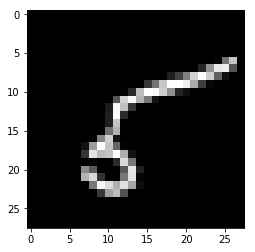

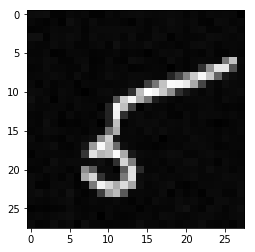

In [39]:
print "Augmenting data..."
_X = [X.copy()]
_y = [y.copy()]
for i in xrange(7):
    _X.append(X.copy() + np.random.normal(scale=3, size=X.shape))
    _y.append(y.copy())
X_aug = np.vstack(_X)
y_aug = np.hstack(_y)

plt.imshow(X[-1].reshape(28,28), cmap="gray")
plt.show()
plt.imshow(X_aug[-1].reshape(28,28), cmap="gray")
plt.show()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.33, random_state=43)

model = KNeighborsClassifier(n_neighbors=1)
print "fitting KNN (with augmentation)"
model.fit(X_train, y_train)
print "train accuracy:", accuracy_score(y_train, model.predict(X_train))
print "test accuracy:", accuracy_score(y_test, model.predict(X_test))

fitting KNN (with augmentation)
train accuracy: 1.0
test accuracy: 1.0


Hurra! Po dodaniu stosunkowo prostej augmentacji danych nasz model nauczył się perfekcyjnie generalizować na zbiór testowy! I nie musieliśmy tu stosować żadnej skomplikowanej sieci neuronowej, wystarczył KNN.

## Ćwiczenie 5 (4 pkt)

Wytłumaczyć, na czym polega błąd w powyższym rozumowaniu.

## Ad 5
Błąd w rozumowaniu polega na tym, że gdy zwiększemy ilość danych przez *Data augmentation*, dane te są do siebie **zbyt podobne**, więc nie powinniśmy używać ich do testowania modelu, a jedynie do jego uczenia.